In [1]:
import numpy as np
import matplotlib.pyplot as plt

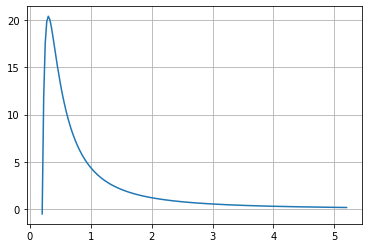

In [2]:
G = 1
c = 1
M = 0.1
r_s = 2 * G * M / c**2

# en el papel se determino que L debe ser mayor
# que r_s * c * sqrt(3)
# para que existan orbitas estables
L0 = r_s * c * np.sqrt(3)
L = L0 + 3

def Veff(r,L,c=c):
    return -G*M/r + L**2 / (2 * r**2) - L**2 * G * M  / (c**2 * r**3)

def Veff_newton(r,L):
     return -G*M/r + L**2 / (2 * r**2)

r = np.linspace(r_s, r_s+5, 200)
plt.grid()
plt.plot(r, Veff(r,L))
plt.show()

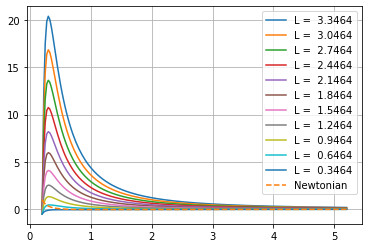

In [3]:
# veamos que ocurre con distintos L
r = np.linspace(r_s, r_s+5, 200)
plt.grid()
# valores de L0 + 0 , ..., L0 + 3
for L in [L0 + 3 - 0.3 * i for i in range(0,11)]:
    plt.plot(r, Veff(r,L), label=f"L = {L : .4f}")

plt.plot(r, Veff_newton(r,L), label="Newtonian", linestyle="dashed")
plt.legend()
plt.show()

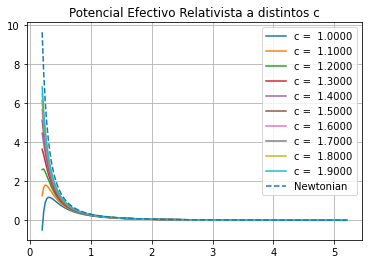

In [4]:
# caso Newton
L = 0.9

# veamos que ocurre con distintos L
r = np.linspace(r_s, r_s+5, 200)
plt.grid()

# valores de L0 + 0 , ..., L0 + 3
for c in [1 + 0.1 * i for i in range(0,10)]:
    plt.plot(r, Veff(r,L,c), label=f"c = {c : .4f}")

plt.plot(r, Veff_newton(r,L), label="Newtonian", linestyle="dashed")

plt.title("Potencial Efectivo Relativista a distintos c")
plt.legend()
plt.show()

# Graficar Orbitas Relativistas

Para resolver se usa el metodo de Heun:

Tengamos una derivada:
$$
\frac{d y}{dt} = f(t,y)
$$

Usamos un valor intermedio
$$
\hat y_{i+1} = y_i + h f(t_i, y_i)
$$

El siguiente paso sera el un promedio entre el paso real y el intermedio
$$
y_{i+1} = y_i + \frac{h}{2} [ f(t_i, y_i) + f(t_{i+1},\hat y_{i+1}) ]
$$

Se llego a la ecuación:
$u = 1/r$

$$
\frac{d^2 u}{d \phi^2} = \frac{\beta}{2 b^2} - u + \frac{3}{2} r_s u^2
$$
- $\beta = \frac{c^2 r_s}{E^2}$
- $b = \frac{L}{E}$

reescribiendola sin las variables intermedias
$$
\frac{d^2 u}{d \phi^2} = \frac{c^2 r_s}{2 L^2} - u + \frac{3}{2} r_s u^2
$$

$$
\frac{d^2 u}{d \phi^2} = \frac{G M}{L^2} - u + 3 \frac{G M}{c^2} u^2
$$

en este desarrollo definimos
$$
u_\text{dot} = \dot u = \frac{du}{d\phi}
$$


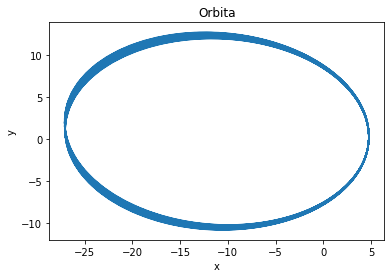

In [18]:
import numpy as np
import matplotlib.pyplot as plt


def f1(phi, u, G, M, L, c): # derivada de d^2u/dphi^2
    #result = (c**2 * r_s / (2 * L*L) - u + (3/2)* r_s * u**2)
    result = (G * M / (L*L)) - u + 3*G*M*u**2 /(c**2)
    return result

def f2(phi,u,udot): # derivada du/dphi
    # notemos que devolvermos udot como tal
    result = udot
    return result

def integration_heun(N, G, M, L, E, 
    u0, udot0, phi0, dphi, c=1, get='all', plot=True,
    threshold=10e20):
    """
    resuelve u=1/r

    get controla el output: all, xy, r, u
    """

    # definimos los estados iniciales
    phi = phi0
    u = u0 # 1/r inicial
    udot = udot0 # d/dtau u
    # luego podemos devolver el cambio
    r = 1/u

    # coord X,Y para graficar
    x = r * np.cos(phi)
    y = r * np.sin(phi)
    t = 0
    tau = 0

    # guardamos los datos
    x_arr = np.zeros(N)
    y_arr = np.zeros(N)

    r_arr = np.zeros(N)
    vel_arr = np.zeros(N)
    u_arr = np.zeros(N)
    udot_arr = np.zeros(N)    

    phi_arr = np.zeros(N)
    t_arr = np.zeros(N)
    tau_arr = np.zeros(N)

    # Evolucionar orbita
    for i in range(N):
        # Avanzar pasos
        u_o = u
        udot_o = udot
        h = dphi

        # Integration using the method of Heun
        # intermediate value
        udot_hat = udot_o + h*f1(phi, u_o, G, M, L, c)
        # then we computa y_i+1
        u = u_o + 0.5*h*(f2(phi,u_o,udot_o) + f2(phi,u_o,udot_hat))

        # intermediate value
        u_hat = u_o + h*f2(phi,u_o,udot_o)
        
        # compute the speed
        udot = udot_o + 0.5*h*(
            f1(phi, u_o, G, M, L, c) + f1(phi, u_hat, G, M, L, c)
            )

        # coordenadas radiales
        r = 1/u # r
        vel = - 1 / (u**2) * udot #dr/dphi

        # Compute time coordinate, with the schw. metric
        d_tau = r * r * dphi / L
        dt = E * d_tau / (1.0 - 2 * G * M / r)

        t = t + dt
        tau = tau + d_tau

        # Compute Cartesian coordinates
        x = r * np.cos(phi)
        y = r * np.sin(phi)

        # Save position data
        x_arr[i] = x
        y_arr[i] = y
        t_arr[i] = t
        tau_arr[i] = tau
        vel_arr[i] = vel
        r_arr[i] = r
        phi_arr[i] = phi
        u_arr[i] = u
        udot_arr[i] = udot

        # Update angle
        phi = phi + dphi

        # detener la simulacion para overflow
        if u > threshold:
            break

    # Plot results
    if plot:
        plt.plot(x_arr, y_arr)
        plt.title("Orbita")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.show()

    #all, xy, r, u
    if get=='all':
        return t_arr, tau_arr, r_arr, vel_arr, phi_arr, u_arr, udot_arr
    
    elif get=='xy':
        return t_arr, phi_arr, x_arr, y_arr

    elif get=='r':
        t_arr, phi_arr, r_arr, vel_arr

    elif get=='u':
        return t_arr, phi_arr, u_arr, udot_arr

    elif get=='xyu':
        return x_arr, y_arr, u_arr, udot_arr

    else:
        print('get = all, xy, r, u')



# Parameters
G = 1.0         # G
c = 1           #

N = 3000        # Pasos totales Simulacion
phi0 = 0        # angulo incial
dphi = 0.05     # step

M = 0.1         # Masa
L = 0.9        # Momentum Angular
E = 0.9         # Energy of orbiting object

# definimos constantes importantes
r_s = 2 * G * M / c**2

udot0 = 0.0       # derivada inicial, osea du/dphi
u0 = 0.21


t, tau, r, rvel, phi, u, udot = integration_heun(N, G, M, L, E, 
    u0, udot0, phi0, dphi,c=100, get='all')


In [19]:
import pandas as pd
data_export = pd.DataFrame({'phi':phi,'t': t,'tau':tau,'r': r,
    'rdot':rvel, 'u':u, 'udot': udot})

data_export.to_csv('heun_c100_u021.csv')

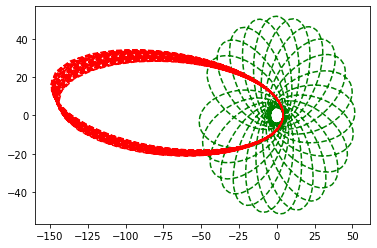

In [144]:
N = 3000

udot0 = 0.0       # derivada inicial, osea du/dphi
u0 = 0.24
c2 = 100

x,y,u,udot = integration_heun(N, G, M, L, E, 
    u0, udot0, phi0, dphi, c=1, plot=False, get='xyu')
plt.plot(x, y, 'g--', label='c=1')

x2,y2,u2,udot2 = integration_heun(N, G, M, L, E, 
    u0, udot0, phi0, dphi, c=c2, plot=False, get='xyu')
plt.plot(x2, y2, 'r--', label='c=2')

plt.show()

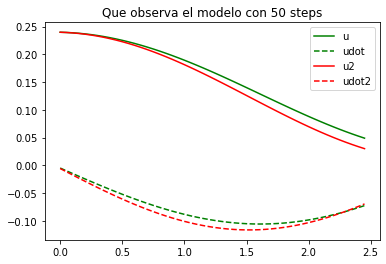

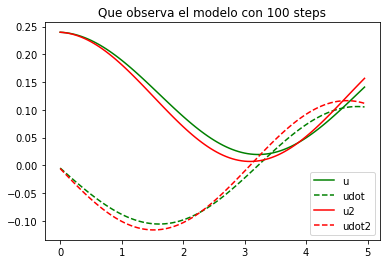

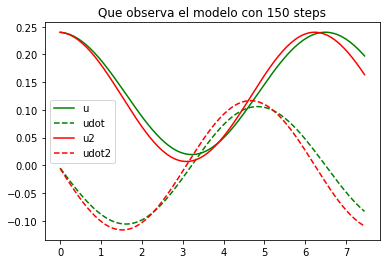

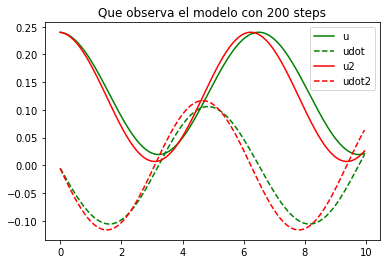

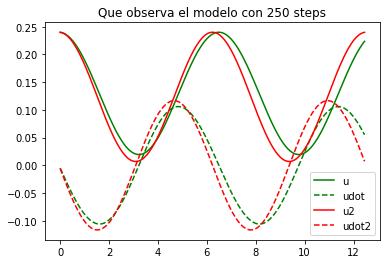

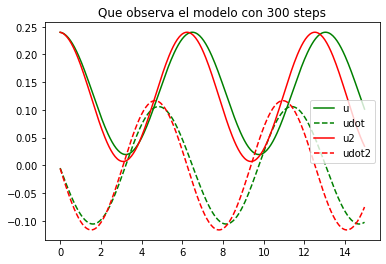

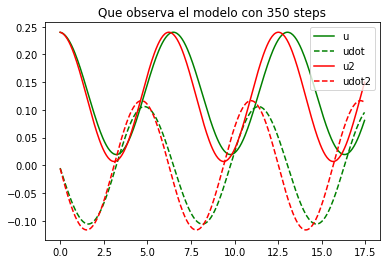

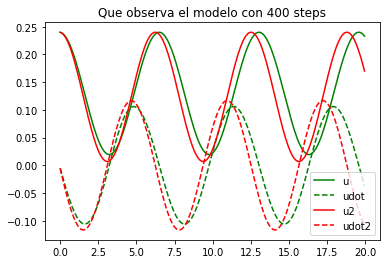

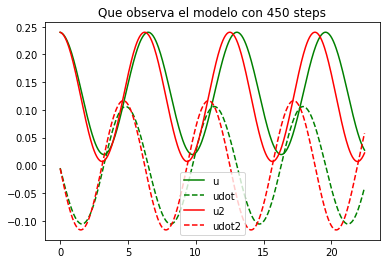

In [145]:
def model_view(end):
    plt.plot(phi[:end], u[:end], 'g', label='u')
    plt.plot(phi[:end], udot[:end], 'g--', label='udot')

    plt.plot(phi[:end], u2[:end], 'r', label='u2')
    plt.plot(phi[:end], udot2[:end], 'r--', label='udot2')
    plt.title(f"Que observa el modelo con {end} steps")


for end in [50*i for i in range(1,10)]:
    model_view(end)
    plt.legend()
    plt.show()


# Como se traduce al modelo

La ecuación de 2do orden:
$$
\frac{d^2 u}{d \phi^2} = \frac{G M}{L^2} - u + 3 \frac{G M}{c^2} u^2
$$

en este desarrollo definimos
$$
u_\text{dot} = \dot u = \frac{du}{d\phi}
$$

La generación de datos debe de entregarnos
- angulo
- u
- udot

La función subyacente que debe resolver para el caso de Newton y Relativista se diferencian por el $\frac{G M}{c^2}$

$$
\frac{d^2 u}{d \phi^2}=\frac{d^2 u}{d \phi^2} = \frac{G M}{L^2} - u + 3 \frac{G M}{c^2} u^2
$$

al tener un $c>>1$ los efectos relativistas comienzan a desaparecer

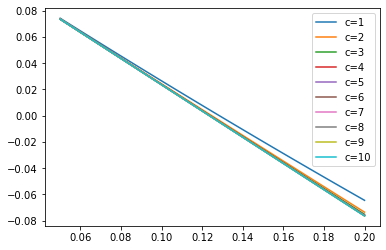

In [124]:
# usamos la función definida previamente:

def f1(phi, u, G, M, L, c): # derivada de d^2u/dphi^2
    #result = (c**2 * r_s / (2 * L*L) - u + (3/2)* r_s * u**2)
    result = (G * M / (L*L)) - u + 3*G*M*u**2 /(c**2)
    return result

u_arr = np.linspace(0.05, 0.2, 100)
c_arr = [1 + 1*i for i in range(0,10)]

for c in c_arr:
    plt.plot(u_arr, f1(0, u_arr, 1, 0.1, 0.9, c), label=f'c={c}')
    plt.legend()
plt.show()

